In [1]:
import numpy as np
from scipy.stats import pearsonr
import scipy.signal as ss
import scipy.stats as scst
import saffy
from saffy.generators.svarog import svarog
import matplotlib.pyplot as plt
from scipy import signal
import mtmvar

In [47]:
pliki = {'open':'mateusz_oczy_szeroko_zamkniete', 'closed':'mateusz_oczy_zamkniete', 'inne':'mateusz_try1'}
EEG2 = saffy.SignalManager(generator=svarog(pliki['closed']))
CH = ['Fp1', 'P3', 'Pz', 'P4', 'Fp2', 'O1', 'O2','A1','A2']
EEG2.butter_highpass_filter(cutoff=1, order=5, method=None)
EEG2.extract_channels(CH)
EEG_2D_F = EEG2.data[0,:,:] #jest tylko jeden zestaw danych
EEG_2D_F = EEG_2D_F - (EEG_2D_F[-1,:] + EEG_2D_F[-2,:])/2 #montaz - średnia z uszu   
EEG_2D_F = EEG_2D_F[0:-2,:] #usuwamy kanały uszne
CH_N = EEG_2D_F.shape[0]

2019-12-23 12:28:48,883 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


In [41]:
syg1 = EEG_2D_F[0,:1000]
# fig = plt.figure(figsize = (25,5))
# plt.plot(syg1, linewidth=4)
# plt.show()

In [109]:
def widmo_AR(syg,p,Fs,step = None):
    if step == None:
        step = 1
    if len(syg.shape) == 1:
        syg = np.reshape(syg,(1,-1))
    freqz = np.arange(0, int(Fs/2),step)
    ch = syg.shape[0]
    A_all, V = mtmvar.mult_AR(syg, p, 1)
    S_all = np.zeros((len(freqz),ch,ch),dtype="complex")
    A = np.eye(ch)
    for ind,fr in enumerate(freqz):
        A_temp = np.zeros((p,A_all.shape[1],A_all.shape[2]),dtype="complex")
        for p_prim in range(p):
            z = np.exp(2*np.pi*1j*fr*1/Fs*(-(p_prim+1)))
            A_temp[p_prim] = A_all[p_prim]*z
        Az = A-np.sum(A_temp,axis=0)
        Az_inv = np.linalg.inv(Az)
        Hf = Az_inv
        Hfconj = np.conj(Hf).T
        S1 = np.dot(Hf,V)
        S2 = np.dot(S1,Hfconj)
        S_all[ind,:,:] = S2
    return freqz,S_all

def proper_widmo_AR(sig,p,Fs,step=None):
    if step == None:
        step = Fs/2
    if len(sig.shape) == 1:
        sig = np.reshape(sig,(1,-1))
    freqz = np.linspace(0, int(Fs/2),step)
    A, V = mtmvar.mult_AR(sig, p, 1)
    oczko = np.eye(A.shape[1])
    oczko = oczko[:,:,np.newaxis]
    z_freqz = np.exp(2*np.pi*1j*freqz*(1/Fs))**np.arange(-1,-p-1,-1).reshape((-1,1,1))
    z_freqz = np.squeeze(z_freqz)
    Az_temp = np.einsum('jik,jn->ikn',A,z_freqz)
    Az = oczko - Az_temp
    Hf = np.einsum('ijk->kij',Az)
    Hf = np.linalg.inv(Hf)
    Hfconj = np.einsum('kij->kji',np.conj(Hf))
    S1 = np.einsum('nij,jk->nik',Hf,V)
    S = np.einsum('hij,hjk->hik',S1,Hfconj)
    return freqz , S

def AIC(syg, min_order, max_order):
    if len(syg.shape) == 1:
        syg = np.reshape(syg,(1,-1))
    aic = np.zeros(max_order-min_order+1)
    k = syg.shape[0]
    N = syg.shape[1]
    for i, p in enumerate(range(min_order, max_order+1)):
        params, V = mtmvar.mult_AR(syg, p, 1)
        aic[i] = np.log(np.linalg.det(V)) + 2*p*k**2/N
    return aic

In [101]:
# AR = []
# for i in range(1,6):
#     AR.append(mtmvar.mult_AR(syg1, i, 1))

In [102]:
aic = AIC(syg1, 1, 20)
# fig = plt.figure(figsize = (15,5))
# plt.xticks(np.arange(1, 21, step=2))
# plt.plot(np.arange(1,21), aic, linewidth=4)
# plt.title('AIC for')
# plt.show()

### Ćwiczenie 2 - wykresy

In [103]:
Signal = EEG_2D_F[4:,21000:22000]
p=17
ch = Signal.shape[0]
freqsy , S_Signal = widmo_AR(Signal,p,EEG2.fs)
# plt.figure(figsize=(16,16))
for i in range(ch):
    for j in range(ch):
#         plt.subplot(ch,ch,i*ch+j+1)
        if i == j:
            widmo = np.abs(np.fft.rfft(Signal[i]))
            freq = np.fft.rfftfreq(len(Signal[i]),1/EEG2.fs)
#             plt.plot(freq,widmo,color = 'orange')
#         plt.plot(S_Signal[:,i,j],color='k')
# plt.show()
# print(S_Signal.shape)
# print(S_Signal[15,:,:])

In [104]:
syg3 = EEG_2D_F[0:6,:1000]
freq = np.fft.rfftfreq(len(syg3[0]),1/EEG2.fs)
p = 250
ch = syg3.shape[0]-3
freqs,S_syg3 = widmo_AR(syg3,p,EEG2.fs,len(freq))
S_syg3 = np.abs(S_syg3)
for i in range(ch):
#     plt.figure(figsize=(12,4))
    widmo = np.abs(np.fft.rfft(syg3[i]))
    freq = np.fft.rfftfreq(len(syg3[i]),1/EEG2.fs)
#     plt.plot(freq,widmo,color = 'orange')
#     plt.plot(freqs,S_syg3[:,i,i],color='k')
#     plt.show()
    print(len(freq), len(freqs))
    print(f'moc sygnału dla rfft: {round(np.sum(widmo),2)} i dla AR: {round(np.sum(S_syg3[:,i,i]),2)}')

# plt.show()

501 1
moc sygnału dla rfft: 88894.05 i dla AR: 0.08
501 1
moc sygnału dla rfft: 75031.8 i dla AR: 17.97
501 1
moc sygnału dla rfft: 84993.46 i dla AR: 23.85


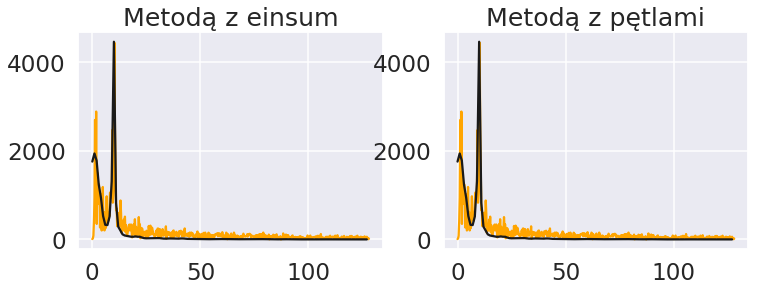

501 128
moc sygnału dla rfft: 88894.05, dla AR (einsum): 18135.54 i dla AR (pętle): 18135.54
maksymalna moc rfft: 4445.35 , AR (einsum): 4466.94 i dla AR (pętle): 4466.94


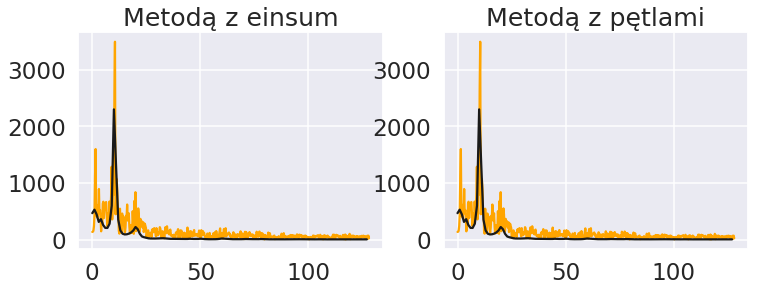

501 128
moc sygnału dla rfft: 75031.8, dla AR (einsum): 9774.0 i dla AR (pętle): 9774.0
maksymalna moc rfft: 3497.01 , AR (einsum): 2300.75 i dla AR (pętle): 2300.75


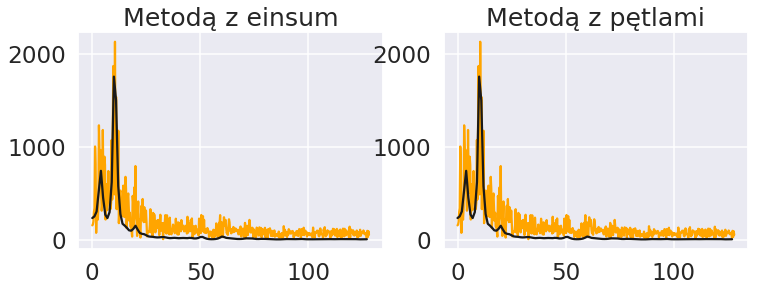

501 128
moc sygnału dla rfft: 84993.46, dla AR (einsum): 10513.82 i dla AR (pętle): 10513.82
maksymalna moc rfft: 2126.8 , AR (einsum): 1752.27 i dla AR (pętle): 1752.27


In [105]:
syg3 = EEG_2D_F[0:6,:1000]
freq = np.fft.rfftfreq(len(syg3[0]),1/EEG2.fs)
p = 36
ch = syg3.shape[0]-3
freqs,S_syg3 = proper_widmo_AR(syg3,p,EEG2.fs,1)
freqs2,S_syg32 = widmo_AR(syg3,p,EEG2.fs)
S_syg3 = np.abs(S_syg3)
S_syg32 = np.abs(S_syg32)
for i in range(ch):
    plt.figure(figsize=(12,4))
    widmo = np.abs(np.fft.rfft(syg3[i]))
    freq = np.fft.rfftfreq(len(syg3[i]),1/EEG2.fs)
    plt.subplot(1,2,1)
    plt.title('Metodą z einsum')
    plt.plot(freq,widmo,color = 'orange')
    plt.plot(freqs,S_syg3[:,i,i],color='k')
    plt.subplot(1,2,2)
    plt.title('Metodą z pętlami')
    plt.plot(freq,widmo,color = 'orange')
    plt.plot(freqs,S_syg32[:,i,i],color='k')
#     plt.legend()
    plt.show()
    print(len(freq), len(freqs))
    print(f'moc sygnału dla rfft: {round(np.sum(widmo),2)}, dla AR (einsum): {round(np.sum(S_syg3[:,i,i]),2)} i dla AR (pętle): {round(np.sum(S_syg32[:,i,i]),2)}')
    print(f'maksymalna moc rfft: {round(np.max(widmo),2)} , AR (einsum): {round(np.max(S_syg3[:,i,i]),2)} i dla AR (pętle): {round(np.max(S_syg32[:,i,i]),2)}')
plt.show()

### TRAININIG WITH SIN

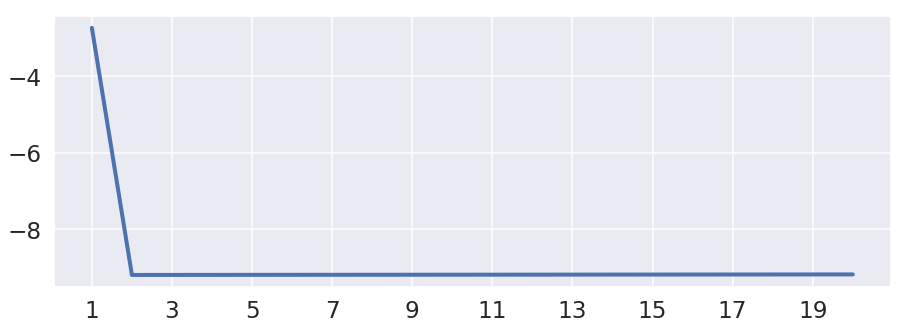

/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/beatka/.local/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


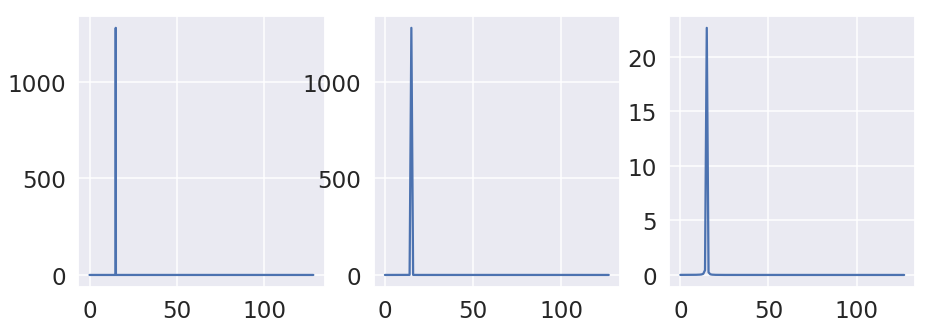

1280.000000000694
1280.568671037845
23.751694620656004


In [112]:
T=10
Fs=256
t = np.arange(0,T,1/Fs)
f = 15
sinus = np.sin(2*np.pi*f*t)
sinus = np.reshape(sinus,(1,-1))
aic = AIC(sinus,1,20)
fig = plt.figure(figsize = (15,5))
plt.xticks(np.arange(1, 21, step=2))
plt.plot(np.arange(1,21), aic, linewidth=4)
plt.show()
plt.figure(figsize=(15,5))
widmo = np.abs(np.fft.rfft(sinus[0]))
freq = np.fft.rfftfreq(len(sinus[0]),1/Fs)
plt.subplot(1,3,1)
plt.plot(freq,widmo)
# plt.show()

p=2
ch=0
fr,S_sinus = widmo_AR(sinus,p,Fs)
plt.subplot(1,3,2)
plt.plot(np.abs(S_sinus[:,ch,ch]))
# plt.show()
Fr , S_sin = proper_widmo_AR(sinus,p,Fs)
plt.subplot(1,3,3)
plt.plot(S_sin[:,ch,ch])
plt.show()
print(np.sum(widmo))
print(np.sum(np.abs(S_sinus[:,ch,ch])))
print(np.sum(np.abs(S_sin[:,ch,ch])))

In [97]:
np.linspace(0,Fs/2,Fs/2)
# print(len(np.linspace(0,Fs/2,Fs/2)))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


array([  0.        ,   1.00787402,   2.01574803,   3.02362205,
         4.03149606,   5.03937008,   6.04724409,   7.05511811,
         8.06299213,   9.07086614,  10.07874016,  11.08661417,
        12.09448819,  13.1023622 ,  14.11023622,  15.11811024,
        16.12598425,  17.13385827,  18.14173228,  19.1496063 ,
        20.15748031,  21.16535433,  22.17322835,  23.18110236,
        24.18897638,  25.19685039,  26.20472441,  27.21259843,
        28.22047244,  29.22834646,  30.23622047,  31.24409449,
        32.2519685 ,  33.25984252,  34.26771654,  35.27559055,
        36.28346457,  37.29133858,  38.2992126 ,  39.30708661,
        40.31496063,  41.32283465,  42.33070866,  43.33858268,
        44.34645669,  45.35433071,  46.36220472,  47.37007874,
        48.37795276,  49.38582677,  50.39370079,  51.4015748 ,
        52.40944882,  53.41732283,  54.42519685,  55.43307087,
        56.44094488,  57.4488189 ,  58.45669291,  59.46456693,
        60.47244094,  61.48031496,  62.48818898,  63.49

In [96]:
np.arange(0,Fs/2)
# print(len(np.arange(0,Fs/2)))

128


In [116]:
print(len(freq))

1281
